In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import OrderedDict 

In [2]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

In [3]:
# acquiring the fashionmnist datasets
dataset = torchvision.datasets.FashionMNIST(
    root = "./data", 
    train = True, 
    download = False,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.FashionMNIST(
    root = "./data", 
    train = False, 
    download = False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
## Don't touch the test data 

split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])

In [7]:
# dataloaders
#shuffle enabled as True for the train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True)
# 
#shuffle enabled as False for the valid dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False) 

#shuffle enabled as False for the test dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False) 

#inspecting the length of datasets (test and train datasets)
num_train_samples=len(trainset)
print(num_train_samples)
num_test_samples=len(testset)
print(num_test_samples)
num_val_samples=len(valset)
print(num_val_samples)

48000
10000
12000


In [8]:
num_pixels = 28*28

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(num_pixels, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x=x.squeeze(1)             #removing the 1 in input batch (resizing from (batch_size,1,28,28) to (batch_size,28,28))
        x=x.view(-1,num_pixels)    #resizing from (batch_size,28*28) to (batch_size,784)
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

loss_func = nn.CrossEntropyLoss()
num_epochs = 40
learning_rate = 1e-4

In [9]:
def train(model, optimizer,model_str,train_loader,val_loader,device,test_loader):

    ts = datetime.now().strftime('%Y%m%d_%H%M%S');
    writer = SummaryWriter(f'runs/fashion_mnist/{ts}');

    test_loss_list = []
    iteration_list = []
    accuracy_list = []
    train_loss_list = []

    count = 0
    for epoch in range(num_epochs):
        train_loss = 0
        for images, labels in train_loader: 
            count += 1

            model.train()

            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)

            train = images.view(-1, num_pixels)

            # Forward pass 
            outputs = model(train)
            loss = loss_func(outputs, labels)

            # back-prop
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()
            train_loss += loss.item() 

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        with torch.no_grad():
            total = 0
            correct = 0
            test_loss = 0
            for images, labels in val_loader:
                model.eval()
                images, labels = images.to(device), labels.to(device)
                
                test = images.view(-1, num_pixels)
                outputs = model(test).cpu()
                test_loss += loss_func(outputs, labels)

                predictions = torch.max(outputs, 1)[1]
                correct += (predictions == labels).sum().numpy()
                total += len(labels)

            accuracy = correct * 100 / total
            test_loss /= len(val_loader)
            test_loss_list.append(test_loss)
            accuracy_list.append(accuracy)

            print(f'Epoch: {epoch+1:02d}, Train Loss: {train_loss:.4f}, Test Loss:{test_loss:.4f} \
                Test Accuracy: {accuracy:.3f}%')     

    writer.add_histogram(model_str+'.hidden.weight', model.hidden.weight, epoch)
    writer.add_histogram(model_str+'output.weight', model.output.weight, epoch)
    writer.close()
    
    print('\nFinished Training ....')

    plt.figure()
    plt.plot(np.arange(num_epochs), train_loss_list, label='Training loss')
    plt.plot(np.arange(num_epochs), test_loss_list, label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Multiclass Cross Entropy Loss')
    plt.legend()
    plt.show()

    print('\nTesting model ....')
    # Test the model with unseen test data
    class_correct = [0. for _ in range(10)]
    total_correct = [0. for _ in range(10)]
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            test = Variable(images)
            test = test.view(-1,num_pixels)
            outputs = model(test).cpu()
            predicted = torch.max(outputs, 1)[1]
            c = (predicted == labels).squeeze()

            for i in range(len(predicted)):
                label = labels[i]
                class_correct[label] += c[i].item()
                total_correct[label] += 1

    print('\nOverall Test Accuracy: %2d%%'%(100. * np.sum(class_correct)/np.sum(total_correct)))  

Epoch: 01, Train Loss: 0.7926, Test Loss:0.5524                 Test Accuracy: 80.867%
Epoch: 02, Train Loss: 0.5065, Test Loss:0.4823                 Test Accuracy: 83.208%
Epoch: 03, Train Loss: 0.4593, Test Loss:0.4541                 Test Accuracy: 84.133%
Epoch: 04, Train Loss: 0.4331, Test Loss:0.4374                 Test Accuracy: 84.392%
Epoch: 05, Train Loss: 0.4141, Test Loss:0.4234                 Test Accuracy: 84.933%
Epoch: 06, Train Loss: 0.4000, Test Loss:0.4030                 Test Accuracy: 85.750%
Epoch: 07, Train Loss: 0.3878, Test Loss:0.4001                 Test Accuracy: 85.975%
Epoch: 08, Train Loss: 0.3775, Test Loss:0.3913                 Test Accuracy: 86.133%
Epoch: 09, Train Loss: 0.3674, Test Loss:0.3838                 Test Accuracy: 86.542%
Epoch: 10, Train Loss: 0.3587, Test Loss:0.3777                 Test Accuracy: 86.742%
Epoch: 11, Train Loss: 0.3517, Test Loss:0.3702                 Test Accuracy: 86.792%
Epoch: 12, Train Loss: 0.3450, Test Loss:0.

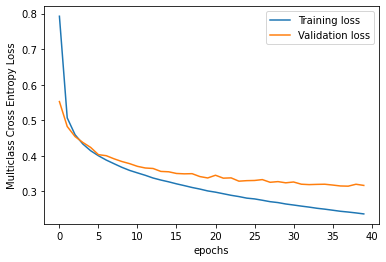


Testing model ....

Overall Test Accuracy: 87%


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, optimizer,"model_1_",trainloader,valloader,device,testloader)

## Analysis
- We can see from the learning curve that the validation loss doesn't converge with training loss
- The validation loss is higher than training loss after 40 epochs
- This is hinting the situation of overfitting
- Even with a very low learning rate (around 1e-4), the model doesn't seem stable. 

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(num_pixels, 48)
        self.dropout = nn.Dropout(p = 0.2)
        self.output = nn.Linear(48, 10)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

Epoch: 01, Train Loss: 1.0145, Test Loss:0.6387                 Test Accuracy: 78.192%
Epoch: 02, Train Loss: 0.6308, Test Loss:0.5389                 Test Accuracy: 81.025%
Epoch: 03, Train Loss: 0.5619, Test Loss:0.4982                 Test Accuracy: 82.375%
Epoch: 04, Train Loss: 0.5225, Test Loss:0.4750                 Test Accuracy: 83.225%
Epoch: 05, Train Loss: 0.4985, Test Loss:0.4558                 Test Accuracy: 83.967%
Epoch: 06, Train Loss: 0.4822, Test Loss:0.4460                 Test Accuracy: 84.225%
Epoch: 07, Train Loss: 0.4664, Test Loss:0.4328                 Test Accuracy: 84.750%
Epoch: 08, Train Loss: 0.4544, Test Loss:0.4251                 Test Accuracy: 84.825%
Epoch: 09, Train Loss: 0.4450, Test Loss:0.4156                 Test Accuracy: 85.133%
Epoch: 10, Train Loss: 0.4355, Test Loss:0.4098                 Test Accuracy: 85.358%
Epoch: 11, Train Loss: 0.4288, Test Loss:0.4038                 Test Accuracy: 85.458%
Epoch: 12, Train Loss: 0.4200, Test Loss:0.

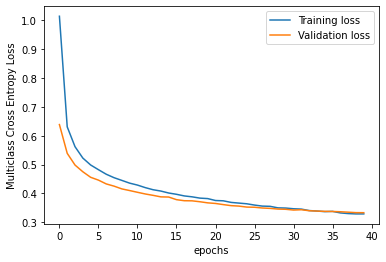


Testing model ....

Overall Test Accuracy: 86%


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
train(model, optimizer,"model_2_",trainloader,valloader,device,testloader)

# Model 1 - Hidden Layer Weights
![Weights_Histogram](model_1_1.png)

# Model 1 - Output Layer Weights
![Weights_Histogram](model_1_2.png)

# Model 2 - Hidden Layer Weights
![Weights_Histogram](model_2_1.png)

# Model 12 - Output Layer Weights
![Weights_Histogram](model_2_2.png)

# Observations 

## For the Hidden Layer 
- The model 1 has maximum value in order of e+4 whereas the model 2 hidden layer has maximum value in order of e+3. This is the effect of the l2 regularization (weight_decay factor) on higher values of weights in model 2. 
- The weights seems evenly distributed across the both sides 0 mean. It looks uniform. 
## For the output layer 
- The model 1 has maximum value is 163 whereas the model 2 hidden layer has maximum value of 52.9
- The effect of regularization and dropout is clearly visible in this layer for model 2. The insignificant features would have their corresponding weights reduced to almost 0. For instance, the weights at -0.11 for model 1 has a peak value of 88 but for model 2 the max value is 13 which shows the effect of regularization and dropout in reducing the coefficients of insignificant features. 

## For Model 1
- The standard deviation range is from -0.610 to .352 
- The weights are larger. Although the weight will be specialized to the training dataset, minor variation or statistical noise on the expected inputs will result in large differences in the output. A model with large weights is more complex than a model with smaller weights. It is a sign of a network that may be overly specialized to training data. This means it is a high varaince low bias scenario (overfitting) which doesnt result in an optimal model. 
- The accuracy for model 1 is higher than that of model 2 by 1%. 

## For Model 2 
- The range of weights is distributed from -0.739 to 0.395. It seems the weights are better distributed than model 1. 
- The L2 regularization (weight_decay factor) introduced to the model forces the weights to decay towards zero (but not exactly zero). 
- The addition of dropout and weight regularization to a neural network has the effect of reducing generalization error and of allowing the model to pay less attention to less relevant input variables. We can see that it helps to prevent overfitting. This is why we can see the CELoss curves of train and validation set to be almost overlapping. 
- The accuracy is compromised by the effect of regularization because it might have reduced the coefficients of some significant featues towards zero and would have lost some critical learning from the features due to which it reduces the accuracy by some value. This is a tradeoff introduced due to regularization and dropouts.  
- We can say that smaller weights makes the model simpler, less sensitve to changes/ noise in the inputs which means it balances the tradeoff between bias and varaince which in turns leads to better generalization of the problem.   